# Práctica Transfer Learning para clasificación de imágenes

En esta práctica, explorarás el concepto de Transfer Learning utilizando el
dataset CIFAR-10. Implementarás modelos con tres arquitecturas diferentes
preentrenadas, comparando su rendimiento, con el objetivo de aprender a
aprovechar modelos preentrenados para resolver problemas de clasificación.

## Descripción del dataset a utilizar

El dataset CIFAR-10 contiene 60,000 imágenes de 32x32 píxeles distribuidas en
10 clases (por ejemplo, aviones, automóviles, pájaros, gatos, etc.). Este dataset
es adecuado para tareas de clasificación de imágenes y es ampliamente utilizado
en la investigación de visión por computadora.

## Parte 1: Preparación
1. Carga del dataset: Utiliza la función load_data() para cargar el dataset
CIFAR-10 (la función está en tensorflow.keras.datasets.cifar10).<br><br>
2. Preprocesamiento de Datos: normaliza las imágenes (escalar los
valores de píxeles entre 0 y 1) y convierte las etiquetas a formato one-hot.

In [23]:
# Genearl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Tensorflow y Keras
import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from keras.src.callbacks import EarlyStopping, ReduceLROnPlateau

In [24]:
(train_X,train_Y), (test_X,test_Y) = tf.keras.datasets.cifar10.load_data()

In [25]:
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (50000, 32, 32, 3) (50000, 1)
Testing data shape :  (10000, 32, 32, 3) (10000, 1)


In [26]:
# Find the unique numbers from the train labels
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)


Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


Text(0.5, 1.0, 'Ground Truth : [3]')

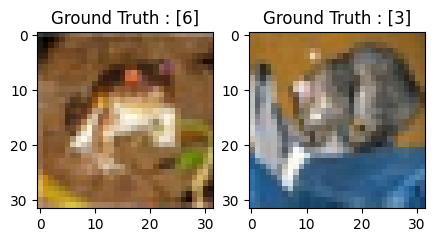

In [27]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))


In [28]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

In [29]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: [6]
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [30]:
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [31]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (40000, 10), (10000, 10))

## Parte 2: Implementación y entrenamiento
1. Arquitecturas: utilizaremos VGG16, ResNet50 e InceptionV3. <br><br>
2. Preparación de las arquitecturas: carga cada uno de los modelos
preentrenados sin las capas superiores (sin la capa de clasificación) y
congela todas las capas. <br><br>
3. Construcción: <br><br>
o VGG16: Usa VGG16 preentrenado en imagenes de ImageNet. <br><br>
o ResNet50: Usa ResNet50 preentrenado. <br><br>
o InceptionV3: Usa InceptionV3 preentrenado. <br><br>
4. Compilación: Utiliza el optimizador Adam y la función de pérdida
categorical_crossentropy. <br><br>
5. Entrenamiento: entrena cada modelo con las imágenes del conjunto de
entrenamiento y evalúa en el conjunto de test. Ajusta el número de épocas
según sea necesario.


In [32]:
# Cargar VGG16 sin la capa de clasificación final
base_model_VGG16 = VGG16(weights='imagenet', include_top=False,
input_shape=(32, 32, 3))
# Congelar las capas convolucionales
for layer in base_model_VGG16.layers:
 layer.trainable = False
# Agregar capas densas personalizadas
x = Flatten()(base_model_VGG16.output)
x = Dense(256, activation='relu')(x)
x = Dense(10, activation='softmax')(x) # Para clasificación binaria
# Crear el modelo final y compilar
model_VGG16 = Model(inputs=base_model_VGG16.input, outputs=x)

In [33]:
# Cargar VGG16 sin la capa de clasificación final
base_model_ResNet50 = ResNet50(weights='imagenet', include_top=False,
input_shape=(32, 32, 3))
# Congelar las capas convolucionales
for layer in base_model_ResNet50.layers:
 layer.trainable = False
# Agregar capas densas personalizadas
x = Flatten()(base_model_ResNet50.output)
x = Dense(256, activation='relu')(x)
x = Dense(10, activation='softmax')(x) # Para clasificación binaria
# Crear el modelo final y compilar
model_ResNet50 = Model(inputs=base_model_ResNet50.input, outputs=x)

In [34]:
# Definir tamaño de imagen adecuado
IMG_SIZE = (75, 75, 3)  # Cambia a (32, 32, 3) si realmente necesitas ese tamaño

# Cargar InceptionV3 sin la capa de clasificación final
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SIZE)

# Congelar las capas convolucionales
for layer in base_model.layers:
    layer.trainable = False

# Agregar capas densas personalizadas
x = Flatten()(base_model.output)  # En lugar de Flatten()
x = Dense(256, activation='relu')(x)
output_layer = Dense(10, activation='softmax')(x)  # Cambia a 1 y 'sigmoid' si es binario

# Crear el modelo final
model_InceptionV3 = Model(inputs=base_model.input, outputs=output_layer)

In [35]:
for img_batch, label_batch in train_dataset.take(1):
    print("Forma de imágenes en batch:", img_batch.shape)
    print("Forma de etiquetas en batch:", label_batch.shape)


Forma de imágenes en batch: (32, 75, 75, 3)
Forma de etiquetas en batch: (32, 10)


In [36]:
# Descongelar algunas capas superiores
for layer in model_VGG16.layers[-4:]: # Descongelar 4 últimas capas
 layer.trainable = True
# Compilar nuevamente con una tasa de aprendizaje baja
model_VGG16.compile(optimizer=Adam(learning_rate=0.00001),
loss='categorical_crossentropy', metrics=['accuracy'])
model_VGG16.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [37]:
# Descongelar algunas capas superiores
for layer in model_ResNet50.layers[-4:]: # Descongelar 4 últimas capas
 layer.trainable = True
# Compilar nuevamente con una tasa de aprendizaje baja
model_ResNet50.compile(optimizer=Adam(learning_rate=0.00001),
loss='categorical_crossentropy', metrics=['accuracy'])
model_ResNet50.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [38]:
# Descongelar algunas capas superiores
for layer in model_InceptionV3.layers[-4:]: # Descongelar 4 últimas capas
 layer.trainable = True
# Compilar nuevamente con una tasa de aprendizaje baja
model_InceptionV3.compile(optimizer=Adam(learning_rate=0.00001),
loss='categorical_crossentropy', metrics=['accuracy'])
model_InceptionV3.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 75, 75, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_188 (Conv2D)       │ (None, 37, 37, 32)     │            864 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_188   │ (None, 37, 37, 32)     │             96 │ conv2d_188[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_188            │ (None, 37, 37, 32)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_189 (Conv2D)       │ (None, 35, 35, 32)     │          9,216 │ activation_188[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_189   │ (None, 35, 35, 32)     │             96 │ conv2d_189[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_189            │ (None, 35, 35, 32)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_190 (Conv2D)       │ (None, 35, 35, 64)     │         18,432 │ activation_189[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_190   │ (None, 35, 35, 64)     │            192 │ conv2d_190[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_190            │ (None, 35, 35, 64)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 17, 17, 64)     │              0 │ activation_190[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_191 (Conv2D)       │ (None, 17, 17, 80)     │          5,120 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_191   │ (None, 17, 17, 80)     │            240 │ conv2d_191[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_191            │ (None, 17, 17, 80)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_192 (Conv2D)  

 Total params: 22,329,898 (85.18 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Entrenar modelos y almacenar sus historiales
histories = {}  # Diccionario para almacenar los historiales

batch_size = 32
epochs = 20
num_classes = 10
histories["VGG16"] = model_VGG16.fit(
    train_X, train_label,
    batch_size=batch_size, epochs=epochs, verbose=1,
    validation_data=(valid_X, valid_label),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1597 - loss: 2.2741 - val_accuracy: 0.3153 - val_loss: 2.0449 - learning_rate: 1.0000e-05
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3444 - loss: 1.9887 - val_accuracy: 0.3894 - val_loss: 1.8591 - learning_rate: 1.0000e-05
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4070 - loss: 1.8138 - val_accuracy: 0.4243 - val_loss: 1.7399 - learning_rate: 1.0000e-05
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4385 - loss: 1.7060 - val_accuracy: 0.4492 - val_loss: 1.6593 - learning_rate: 1.0000e-05
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4609 - loss: 1.6306 - val_accuracy: 0.4618 - val_loss: 1.6016 - learning_rate: 1.0000e-05
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4727 - loss: 1.5797 - val_accuracy: 0.4720 - val_loss: 1.5572 - learning_rate: 1.0000e-05
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/st

In [40]:
histories["ResNet50"] = model_ResNet50.fit(
    train_X, train_label,
    batch_size=batch_size, epochs=epochs, verbose=1,
    validation_data=(valid_X, valid_label),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.1447 - loss: 2.4341 - val_accuracy: 0.1722 - val_loss: 2.2351 - learning_rate: 1.0000e-05
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.1960 - loss: 2.2129 - val_accuracy: 0.2168 - val_loss: 2.1779 - learning_rate: 1.0000e-05
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.2353 - loss: 2.1615 - val_accuracy: 0.2482 - val_loss: 2.1360 - learning_rate: 1.0000e-05
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.2614 - loss: 2.1187 - val_accuracy: 0.2730 - val_loss: 2.1018 - learning_rate: 1.0000e-05
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.2734 - loss: 2.0907 - val_accuracy: 0.2736 - val_loss: 2.0777 - learning_rate: 1.0000e-05


In [41]:
def preprocess(image, label):
    image = tf.image.resize(image, (75, 75))  # Redimensionar
    return image, label

# Crear datasets redimensionados
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_label)).map(preprocess).batch(batch_size)
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_X, valid_label)).map(preprocess).batch(batch_size)

# Entrenar el modelo con el dataset
histories["InceptionV3"] = model_InceptionV3.fit(
    train_dataset,
    epochs=epochs,
    verbose=1,
    validation_data=valid_dataset,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.1835 - loss: 2.2562 - val_accuracy: 0.3870 - val_loss: 1.8117 - learning_rate: 1.0000e-05
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.4251 - loss: 1.7203 - val_accuracy: 0.4717 - val_loss: 1.5691 - learning_rate: 1.0000e-05
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.4988 - loss: 1.5040 - val_accuracy: 0.5092 - val_loss: 1.4444 - learning_rate: 1.0000e-05
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.5373 - loss: 1.3851 - val_accuracy: 0.5328 - val_loss: 1.3700 - learning_rate: 1.0000e-05
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.5607 - loss: 1.3091 - val_accuracy: 0.5492 - val_loss: 1.3206 - learning_rate: 1.0000e-05
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.5769 - loss: 1.2555 - val_accuracy: 0.5592 - val_loss: 1.2854 - learning_rate: 1.0000e-05
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━

## Parte 3: Evaluación
1. Obtención de métricas: evalúa los tres modelos utilizando el conjunto de
prueba y compara su precisión. Genera las gráficas de pérdida y
precisión, así como la matriz de confusión y el informe de clasificación.<br><br>
2. Comparación de resultados: compara las métricas de precisión de los
tres modelos. ¿Cuál de los modelos tiene mejor rendimiento? ¿Por qué
crees que ocurre esto? ¿Cómo afecta la arquitectura del modelo
preentrenado al rendimiento en el dataset CIFAR-10? ¿Crees que el
modelo con más parámetros siempre es el mejor? Justifica tu respuesta

In [42]:
test_eval = model_VGG16.evaluate(test_X, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])


Test loss: 1.347553014755249
Test accuracy: 0.5327000021934509


In [43]:
test_eval = model_ResNet50.evaluate(test_X, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])


Test loss: 2.2258048057556152
Test accuracy: 0.18019999563694


In [45]:
# Redimensionar las imágenes de test a 75x75
test_X_incep = tf.image.resize(test_X, (75, 75))

# Ahora puedes evaluar
test_eval = model_InceptionV3.evaluate(test_X_incep, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])


Test loss: 1.143646240234375
Test accuracy: 0.6123999953269958


In [46]:
predicted_classes_VGG16 = model_VGG16.predict(test_X)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [48]:
predicted_classes_InceptionV3 = model_InceptionV3.predict(test_X_incep)

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step


In [49]:
predicted_classes_ResNet50 = model_ResNet50.predict(test_X)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step


In [50]:
def plot_training_history(history, model_name):
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(accuracy))

    plt.figure(figsize=(12, 5))

    # Gráfico de precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy - {model_name}')
    plt.legend()

    # Gráfico de pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title(f'Training and Validation Loss - {model_name}')
    plt.legend()

    plt.show()

def print_classification_report(true_labels, predicted_labels, model_name, num_classes=10):
    target_names = [f"Class {i}" for i in range(num_classes)]
    print(f'Classification Report - {model_name}')
    print(classification_report(true_labels, predicted_labels, target_names=target_names))

def plot_confusion_matrix(true_labels, predicted_labels, model_name, num_classes=10):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    labels = [f"Class {i}" for i in range(num_classes)]
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

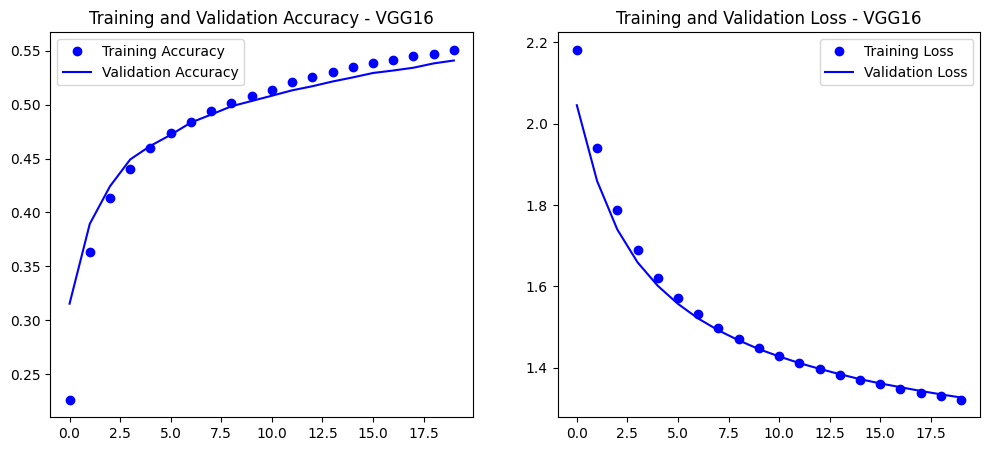

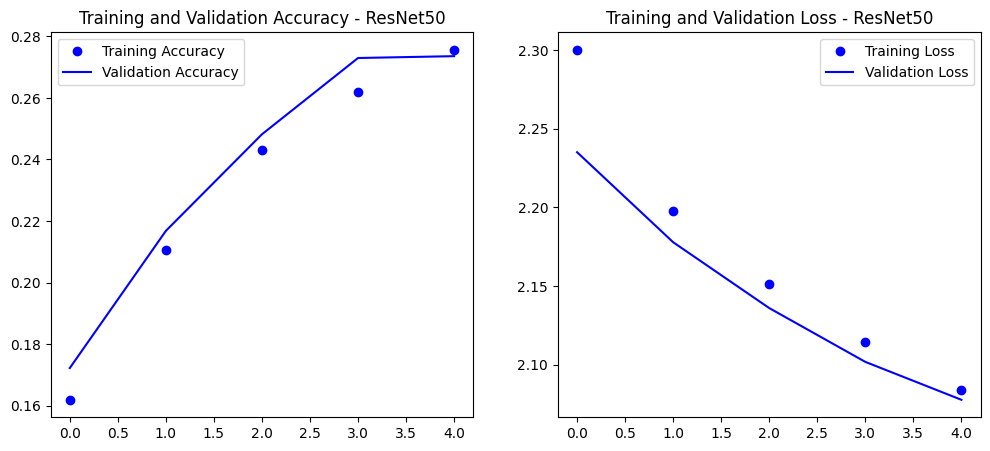

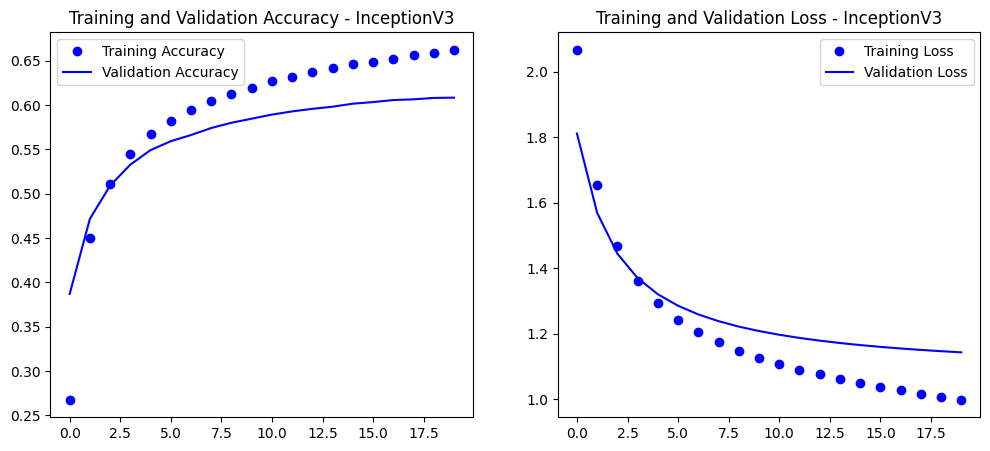

In [51]:
# Lista de modelos y sus nombres
models = {
    "VGG16": model_VGG16,
    "ResNet50": model_ResNet50,
    "InceptionV3": model_InceptionV3
}

# Graficar historia de entrenamiento para cada modelo
for name, history in histories.items():
    plot_training_history(history.history, name)  # Se accede a history.history correctamente

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Classification Report - VGG16
              precision    recall  f1-score   support

     Class 0       0.60      0.60      0.60      1000
     Class 1       0.55      0.61      0.58      1000
     Class 2       0.46      0.37      0.41      1000
     Class 3       0.39      0.38      0.38      1000
     Class 4       0.53      0.48      0.51      1000
     Class 5       0.50      0.48      0.49      1000
     Class 6       0.54      0.65      0.59      1000
     Class 7       0.56      0.56      0.56      1000
     Class 8       0.63      0.68      0.65      1000
     Class 9       0.54      0.52      0.53      1000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.53     10000
weighted avg       0.53      0.53      0.53     10000



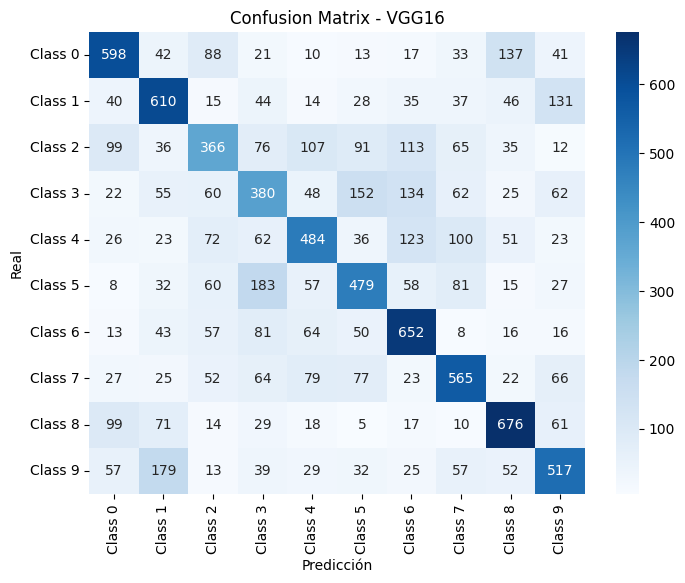

Classification Report - ResNet50
              precision    recall  f1-score   support

     Class 0       0.21      0.22      0.21      1000
     Class 1       0.32      0.10      0.16      1000
     Class 2       0.17      0.18      0.17      1000
     Class 3       0.00      0.00      0.00      1000
     Class 4       0.29      0.01      0.02      1000
     Class 5       0.16      0.01      0.02      1000
     Class 6       0.00      0.00      0.00      1000
     Class 7       0.16      0.74      0.26      1000
     Class 8       0.19      0.54      0.28      1000
     Class 9       0.39      0.01      0.02      1000

    accuracy                           0.18     10000
   macro avg       0.19      0.18      0.11     10000
weighted avg       0.19      0.18      0.11     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


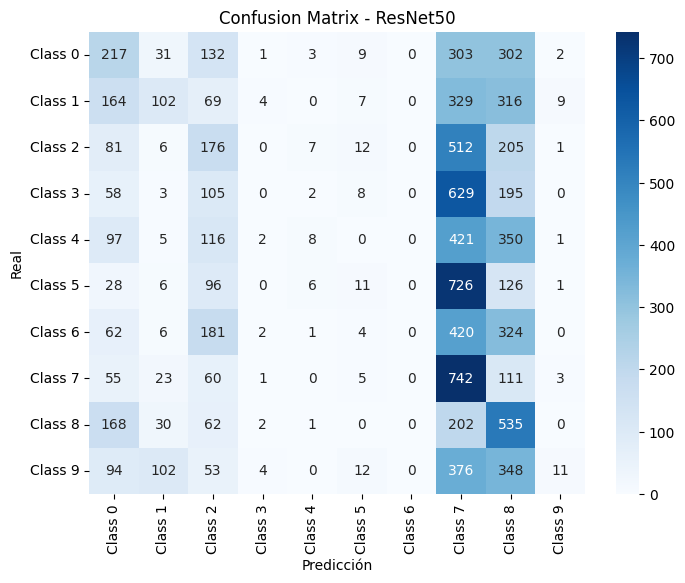

Classification Report - InceptionV3
              precision    recall  f1-score   support

     Class 0       0.65      0.67      0.66      1000
     Class 1       0.72      0.69      0.71      1000
     Class 2       0.54      0.48      0.50      1000
     Class 3       0.46      0.45      0.45      1000
     Class 4       0.55      0.57      0.56      1000
     Class 5       0.62      0.56      0.59      1000
     Class 6       0.58      0.66      0.62      1000
     Class 7       0.66      0.65      0.65      1000
     Class 8       0.66      0.69      0.67      1000
     Class 9       0.69      0.70      0.69      1000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000



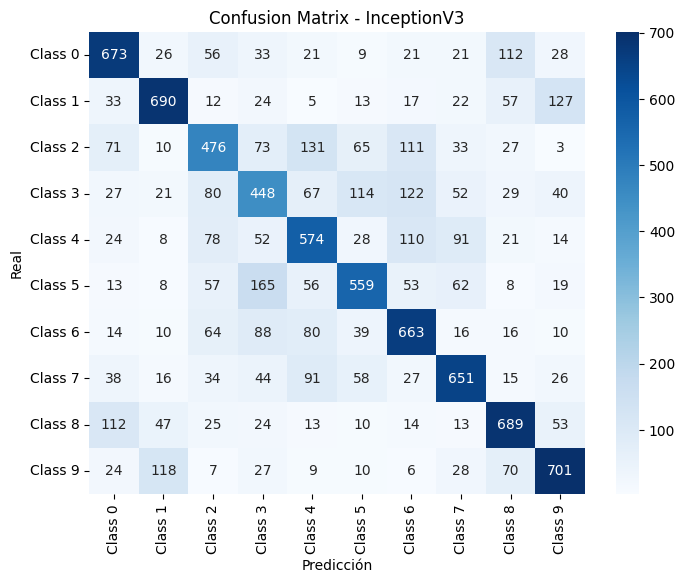

In [53]:
# Convertir probabilidades en etiquetas de clase
predicted_classes_VGG16 = np.argmax(model_VGG16.predict(test_X), axis=1)
predicted_classes_ResNet50 = np.argmax(model_ResNet50.predict(test_X), axis=1)
predicted_classes_Inception = np.argmax(model_InceptionV3.predict(test_X_incep), axis=1)

# Diccionario con predicciones corregidas
predicted_classes = {
    "VGG16": predicted_classes_VGG16,
    "ResNet50": predicted_classes_ResNet50,
    "InceptionV3": predicted_classes_Inception
}

# Convertir etiquetas reales si están en one-hot encoding
if test_Y.shape[1] > 1:  # Si es one-hot encoded
    test_Y = np.argmax(test_Y, axis=1)

# Evaluar clasificación para cada modelo
for name, preds in predicted_classes.items():
    print_classification_report(test_Y, preds, name)
    plot_confusion_matrix(test_Y, preds, name)